In [95]:
%matplotlib inline

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [96]:
df = pd.read_csv('video Metrics.tsv', sep='\t')

In [97]:
df = df[['Participant', 'Interval', 'Event_type', 'Start', 'Duration', 'FixationPointX', 'FixationPointY', 'Average_pupil_size']]

indexNames = df[ (df['FixationPointX'] < 0) | (df['FixationPointX'] > 1) | (df['FixationPointY'] < 0) | (df['FixationPointY'] > 1) | (df['Participant'] == 'Jelle2')].index
df.drop(indexNames , inplace=True)
df.dropna()

,Participant,Interval,Event_type,Start,Duration,FixationPointX,FixationPointY,Average_pupil_size
0,Jelle,1,Fixation,0,8,0.56187,0.54535,3.26456
1,Jelle,1,Fixation,8,8,0.55963,0.54667,3.28905
2,Jelle,1,Fixation,16,8,0.55903,0.53809,3.27068
3,Jelle,1,Fixation,24,8,0.56226,0.55613,3.30061
4,Jelle,1,Fixation,33,8,0.55881,0.55414,3.28229
...,...,...,...,...,...,...,...,...
16444,Jelle,1,Fixation,72826,8,0.48715,0.55074,3.24483
16445,Jelle,1,Fixation,72834,8,0.49240,0.54838,3.20264
16446,Jelle,1,Fixation,72843,8,0.49301,0.55430,3.22996
16447,Jelle,1,Fixation,72851,8,0.48833,0.53229,3.18259


In [98]:
df['X'] = df['FixationPointX'] * 1280
df['Y'] = df['FixationPointY'] * 720

xMin = df['X'].min()
xMax = df['X'].max()

yMin = df['Y'].min()
yMax = df['Y'].max()

print(f"X min: {xMin}, X max: {xMax}, Y min: {yMin}, X max: {yMax}")



X min: 249.0624, X max: 1001.8048, Y min: 25.408800000000003, X max: 666.432


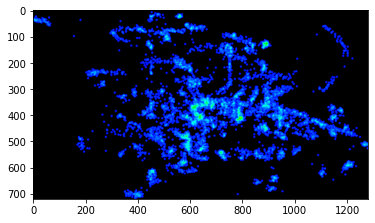

In [102]:
data = df.loc[(df['Start'] > 0) & (df['Start'] < 70000)]

X = np.array(data['X'].values).astype(np.uint16)
Y = np.array(data['Y'].values).astype(np.uint16)

heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(1280, 720), range=[[xMin, xMax], [yMin, yMax]])
heatmap *= 255
heatmap = heatmap.astype(np.uint8).T
heatmap = gaussian_filter(heatmap, sigma=2)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV)
heatmap[np.where((heatmap==[0, 0, 255]).all(axis=2))] = [0, 0, 0]


plt.imshow(heatmap)